#### Set up
Run this section before anything else

In [65]:
from datetime import datetime, timedelta
import Dataloader_ricequant
import pandas as pd
import rqdatac as rq
from constants import *
import scipy
import statsmodels as sm
import numpy as np
import seaborn as sns
import pathos
from tqdm.notebook import tqdm
import multiprocessing
import pickle
import matplotlib.pyplot as plt

In [8]:
def applyParallel(dfGrouped, func):
    #parrallel computing version of pd.groupby.apply, works most of the time but not always
    #I mainly use it for cases where func takes in a dataframe and outputs a dataframe or a series
    with pathos.multiprocessing.ProcessPool(pathos.helpers.cpu_count()) as pool:
        ret_list = pool.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

In [9]:
Dataloader_ricequant.rq_initialize()

/Users/zhengboyu/opt/anaconda3/lib/python3.9/site-packages/rqdatac/client.py:236: UserWarning: Your account will be expired after  104 days. Please call us at 0755-22676337 to upgrade or purchase or renew your contract.
  warnings.warn("Your account will be expired after  {} days. "


In [73]:
def sort_index_and_col(df) -> pd.DataFrame:
    #sort the dataframe by index and column
    return df.sort_index(axis=0).reindex(sorted(df.columns), axis=1)
    #the following might achieve the same result in a cleaner way
    # return df.sort_index(axis=0).sort_index(axis=1)

In [74]:
results = Dataloader_ricequant.load_basic_info()

In [75]:
results

[         code        date   open   high    low  close    change      volume  \
 0    sh688136  2021-07-30  34.12  34.71  33.30  34.40  0.009982   2632244.0   
 1    sh688136  2021-07-29  34.50  34.50  33.59  34.06  0.004423   2219402.0   
 2    sh688136  2021-07-28  33.01  34.30  32.03  33.91  0.023235   2247943.0   
 3    sh688136  2021-07-27  33.10  34.15  33.00  33.14  0.002117   1240265.0   
 4    sh688136  2021-07-26  33.84  34.14  32.91  33.07 -0.022176   1641350.0   
 ..        ...         ...    ...    ...    ...    ...       ...         ...   
 149  sh688136  2020-12-18  46.80  46.90  43.10  43.51 -0.095426  11982744.0   
 150  sh688136  2020-12-17  46.00  51.59  45.60  48.10  0.023404  12590461.0   
 151  sh688136  2020-12-16  48.52  52.39  46.60  47.00 -0.106634  17219496.0   
 152  sh688136  2020-12-15  38.26  55.66  38.20  52.61  0.282858  25221834.0   
 153  sh688136  2020-12-14  44.00  44.36  38.00  41.01  0.836543  27380888.0   
 
             money  traded_market_valu

#### Load Industry Data

In [76]:
df_indus_mapping = Dataloader_ricequant.load_industry_mapping()

In [77]:
df_indus_mapping

,secon_indus_code,pri_indus_code
000998.XSHE,A01,A
002041.XSHE,A01,A
002772.XSHE,A01,A
300087.XSHE,A01,A
300189.XSHE,A01,A
...,...,...
600620.XSHG,S90,S
600673.XSHG,S90,S
600766.XSHG,S90,S
600770.XSHG,S90,S


#### Load Index Data

(这部分似乎不用管）

In hiearachical backtesting we need weights of index(e.g. CSI300) data to make the portfolio to stay industry-neutral with the index.

Currently index data is assumed to be uniformly weighted among all stocks

In [21]:
# CSI 300 沪深300
#index = pd.read_csv(dl.DATAPATH + 'index_data/' + 'sh000300.csv',usecols=['date', 'open','close','change'],index_col=['date']).sort_index(ascending=True)
#index

In [22]:
#((index['change'] + 1).cumprod() - 1).plot()

### Data Preprocessing Part 1

Major Steps: 

0) Read all csv's and concatenate the desired column from each dataframe

1) Filter out data before START_DATE and after END_DATE(backtesting period) from the raw stock data. 

- 剔除不在回测区间内的股票信息

2) Filter listed stocks

- 选出回测区间内每只股票上市的时间。这一步是为了步骤3，因为在每个选股日筛选ST或者停牌股的前提是股票在该选股日已上市。

3) Filter out ST stocks, suspended stocks and stocks that are listed only within one year
- 剔除ST，停牌和次新股（上市未满一年的股票）


In [78]:
# step 0
df_backtest = pd.concat(results, axis=0).rename(columns={'code': 'stock'}).loc[:, INDEX_COLS + BASIC_INFO_COLS]
df_backtest['date'] = pd.to_datetime(df_backtest['date'])

# step 1
df_backtest = df_backtest[ (START_DATE <= df_backtest['date']) & (df_backtest['date'] <= END_DATE) ]
df_backtest['stock'] = df_backtest['stock'].apply(lambda stock: Dataloader_ricequant.normalize_code(stock))

In [79]:
df_backtest

,date,stock,PE_TTM,PS_TTM,PC_TTM,PB,market_value,open,close
140,2020-12-31,688136.XSHG,NaN,NaN,NaN,NaN,8.115000e+09,39.75,40.84
141,2020-12-30,688136.XSHG,NaN,NaN,NaN,NaN,7.898000e+09,39.50,39.75
142,2020-12-29,688136.XSHG,NaN,NaN,NaN,NaN,7.966000e+09,42.60,40.09
143,2020-12-28,688136.XSHG,NaN,NaN,NaN,NaN,8.353000e+09,40.79,42.04
144,2020-12-25,688136.XSHG,NaN,NaN,NaN,NaN,8.018000e+09,39.81,40.35
...,...,...,...,...,...,...,...,...,...
2554,2011-01-10,600415.XSHG,35.599957,7.796923,-40.068847,6.553304,4.600877e+10,35.24,33.81
2555,2011-01-07,600415.XSHG,37.189900,8.145144,-41.858377,6.845983,4.806358e+10,36.49,35.32
2556,2011-01-06,600415.XSHG,38.379709,8.405731,-43.197544,7.065006,4.960129e+10,35.35,36.45
2557,2011-01-05,600415.XSHG,37.010898,8.105940,-41.656905,6.813033,4.783224e+10,34.80,35.15


In [80]:
# have a (date_stock) multi-index dataframe 重新设置datafram的key
df_backtest = df_backtest.set_index(INDEX_COLS).sort_index()
df_backtest = df_backtest.unstack(level=1).stack(dropna=False)
df_backtest

PE_TTM     PS_TTM      PC_TTM         PB  \
date       stock                                                      
2011-01-04 000001.XSHE   8.865369   3.275312    1.187931   1.736868   
           000002.XSHE  17.143047   2.319354  -30.282091   2.403611   
           000004.XSHE  72.239436   8.031760   71.600273  14.373444   
           000005.XSHE -53.807405  79.472714  165.599447   5.077750   
           000006.XSHE  15.341738   1.899546  269.949866   2.643284   
...                           ...        ...         ...        ...   
2020-12-31 688699.XSHG        NaN        NaN         NaN        NaN   
           688777.XSHG        NaN        NaN         NaN        NaN   
           688788.XSHG        NaN        NaN         NaN        NaN   
           688981.XSHG        NaN        NaN         NaN        NaN   
           689009.XSHG        NaN        NaN         NaN        NaN   

                        market_value    open   close  
date       stock                                      
2011-01-04 000001.XSHE  5.582992e+10   15.82   16.02  
           000002.XSHE  8.518624e+10    8.27    8.80  
           000004.XSHE  1.015278e+09   12.14   12.09  
           000005.XSHE  3.428751e+09    3.68    3.75  
           000006.XSHE  5.530833e+09    7.05    7.27  
...                              ...     ...     ...  
2020-12-31 688699.XSHG  4.103000e+09   54.00   55.17  
           688777.XSHG  4.922700e+10   99.58  100.20  
           688788.XSHG  1.006900e+10  134.49  133.30  
           688981.XSHG  4.448770e+11   57.00   57.75  
           689009.XSHG  6.042500e+10   82.00   85.82  

[10204672 rows x 7 columns]

In [81]:
# check stock index
stock_names = df_backtest.index.get_level_values(1).unique()
stock_names

Index(['000001.XSHE', '000002.XSHE', '000004.XSHE', '000005.XSHE',
       '000006.XSHE', '000007.XSHE', '000008.XSHE', '000009.XSHE',
       '000010.XSHE', '000011.XSHE',
       ...
       '688668.XSHG', '688678.XSHG', '688679.XSHG', '688686.XSHG',
       '688698.XSHG', '688699.XSHG', '688777.XSHG', '688788.XSHG',
       '688981.XSHG', '689009.XSHG'],
      dtype='object', name='stock', length=4196)

In [82]:
# step 2
# get the listed date
listed_dates = {dl.normalize_code(result['code'][0]): result['date'].min() for result in results}
listed_dates = pd.DataFrame(pd.Series(listed_dates), columns=['listed_date']).sort_index()
# left join with dataframe 'listed_dates'
df_backtest = df_backtest.merge(listed_dates, left_on = 'stock', right_index=True, how='left')
# create a new variable called 'is_listed' to check if a certain stock is listed at that given date
df_backtest['is_listed'] = (df_backtest.index.get_level_values(level=0) >= df_backtest['listed_date'])

<AxesSubplot:xlabel='date'>

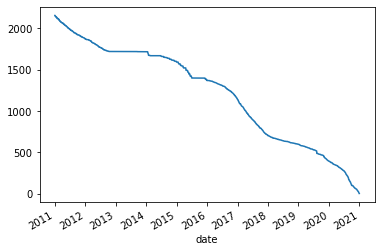

In [83]:
# number of non-listed stocks along the time
non_listed = df_backtest[df_backtest['is_listed'] == False]
num_nonlisted_stock = non_listed.groupby(level=0).count()['is_listed']
num_nonlisted_stock.plot.line()

In [84]:
df_backtest

PE_TTM     PS_TTM      PC_TTM         PB  \
date       stock                                                      
2011-01-04 000001.XSHE   8.865369   3.275312    1.187931   1.736868   
           000002.XSHE  17.143047   2.319354  -30.282091   2.403611   
           000004.XSHE  72.239436   8.031760   71.600273  14.373444   
           000005.XSHE -53.807405  79.472714  165.599447   5.077750   
           000006.XSHE  15.341738   1.899546  269.949866   2.643284   
...                           ...        ...         ...        ...   
2020-12-31 688699.XSHG        NaN        NaN         NaN        NaN   
           688777.XSHG        NaN        NaN         NaN        NaN   
           688788.XSHG        NaN        NaN         NaN        NaN   
           688981.XSHG        NaN        NaN         NaN        NaN   
           689009.XSHG        NaN        NaN         NaN        NaN   

                        market_value    open   close listed_date  is_listed  
date       stock                                                             
2011-01-04 000001.XSHE  5.582992e+10   15.82   16.02  1991-04-03       True  
           000002.XSHE  8.518624e+10    8.27    8.80  1991-01-29       True  
           000004.XSHE  1.015278e+09   12.14   12.09  1991-01-14       True  
           000005.XSHE  3.428751e+09    3.68    3.75  1991-01-04       True  
           000006.XSHE  5.530833e+09    7.05    7.27  1992-04-27       True  
...                              ...     ...     ...         ...        ...  
2020-12-31 688699.XSHG  4.103000e+09   54.00   55.17  2020-12-18       True  
           688777.XSHG  4.922700e+10   99.58  100.20  2020-11-24       True  
           688788.XSHG  1.006900e+10  134.49  133.30  2020-10-22       True  
           688981.XSHG  4.448770e+11   57.00   57.75  2020-07-16       True  
           689009.XSHG  6.042500e+10   82.00   85.82  2020-10-29       True  

[10204672 rows x 9 columns]

In [85]:
# load st/suspend data from Ricequant
df_is_st = dl.load_st_data(stock_names)
df_is_suspended = dl.load_suspended_data(stock_names)

In [86]:
df_is_st

2011-01-04  000001.XSHE    False
            000002.XSHE    False
            000004.XSHE     True
            000005.XSHE    False
            000006.XSHE    False
                           ...  
2020-12-31  688699.XSHG    False
            688777.XSHG    False
            688788.XSHG    False
            688981.XSHG    False
            689009.XSHG    False
Length: 10204672, dtype: bool

In [87]:
# step 3
#create ST and suspended columns
df_backtest['is_st'] = df_is_st.values
df_backtest['is_suspended'] = df_is_suspended.values
# filter out stocks that are listed within a year
df_backtest = df_backtest[df_backtest['listed_date']<'2020-01-01']
#filter out ST and suspended stocks, filter data by the stock's listed date
df_backtest = df_backtest.loc[ (~df_backtest['is_st']) & (~df_backtest['is_suspended']) & (df_backtest['is_listed']), BASIC_INFO_COLS]
#keep data only on the rebalancing dates
rebalancing_dates = pd.date_range(start=START_DATE, end=END_DATE, freq='BM')
df_backtest = df_backtest[df_backtest.index.get_level_values(0).isin(rebalancing_dates)]

In [88]:
df_backtest

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
           000009.XSHE  61.799492   6.153490  -26.665920  8.004300   
...                           ...        ...         ...       ...   
2020-12-31 688368.XSHG        NaN        NaN         NaN       NaN   
           688369.XSHG        NaN        NaN         NaN       NaN   
           688388.XSHG        NaN        NaN         NaN       NaN   
           688389.XSHG        NaN        NaN         NaN       NaN   
           688399.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  
date       stock                                      
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31  
           000002.XSHE  7.937809e+10    8.25    8.20  
           000005.XSHE  3.200168e+09    3.46    3.50  
           000006.XSHE  5.409109e+09    7.15    7.11  
           000009.XSHE  1.937173e+10   17.05   17.76  
...                              ...     ...     ...  
2020-12-31 688368.XSHG  1.060100e+10  159.42  172.09  
           688369.XSHG  5.913000e+09   77.35   76.80  
           688388.XSHG  2.034900e+10   86.90   88.14  
           688389.XSHG  8.866000e+09   21.20   21.00  
           688399.XSHG  1.127500e+10  190.40  192.34  

[307662 rows x 7 columns]

In [89]:
# the current rebalancing date is the last trading day of the current period
# 'next_period_open' is defined as the stock's open price on the next relancing date
# 'next_period_return' is the generated return by holding a stock from EOD of current rebalancing date to the start of the next rebalancing date
df_backtest['next_period_open'] = df_backtest['open'].groupby(level=1).shift(-1).values
df_backtest['next_period_return'] = (df_backtest['next_period_open'].values - df_backtest['close'].values) / df_backtest['close'].values
df_backtest = df_backtest[df_backtest.index.get_level_values(0) != df_backtest.index.get_level_values(0).max()]

In [96]:
#df_backtest为不带因子数据只带股票数据的dataset
df_store = df_backtest.copy(deep=True)   #复制一份以防丢失
df_backtest.to_hdf(DATAPATH + f'data.h5', key='stock')  #将df_backtest存储为.h5文件
df_backtest

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
           000009.XSHE  61.799492   6.153490  -26.665920  8.004300   
...                           ...        ...         ...       ...   
2020-11-30 688368.XSHG        NaN        NaN         NaN       NaN   
           688369.XSHG        NaN        NaN         NaN       NaN   
           688388.XSHG        NaN        NaN         NaN       NaN   
           688389.XSHG        NaN        NaN         NaN       NaN   
           688399.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  next_period_open  \
date       stock                                                         
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31             15.81   
           000002.XSHE  7.937809e+10    8.25    8.20              8.13   
           000005.XSHE  3.200168e+09    3.46    3.50              4.28   
           000006.XSHE  5.409109e+09    7.15    7.11              7.22   
           000009.XSHE  1.937173e+10   17.05   17.76             23.50   
...                              ...     ...     ...               ...   
2020-11-30 688368.XSHG  1.207400e+10  210.19  196.00            159.42   
           688369.XSHG  5.361000e+09   69.03   69.63             77.35   
           688388.XSHG  1.385300e+10   62.18   60.00             86.90   
           688389.XSHG  8.246000e+09   19.33   19.53             21.20   
           688399.XSHG  1.083200e+10  185.00  184.79            190.40   

                        next_period_return  
date       stock                            
2011-01-31 000001.XSHE            0.032658  
           000002.XSHE           -0.008537  
           000005.XSHE            0.222857  
           000006.XSHE            0.015471  
           000009.XSHE            0.323198  
...                                    ...  
2020-11-30 688368.XSHG           -0.186633  
           688369.XSHG            0.110872  
           688388.XSHG            0.448333  
           688389.XSHG            0.085509  
           688399.XSHG            0.030359  

[304082 rows x 9 columns]

### Load Factor

In [66]:
#测因子前先修改TESTING_FACTOR的名称
TESTING_FACTOR = ['return_on_asset_ttm']

In [67]:
#下载因子数据
with open('./Data/raw_data/stock_names.h5', 'rb') as fp:
     stock_names = pickle.load(fp)

In [68]:
Dataloader_ricequant.download_factor_data(stock_names, TESTING_FACTOR[0], START_DATE,END_DATE)
#download_factor_data()会将因子数据下载到factor_data文件夹内存储成.h5

In [69]:
df = pd.read_hdf(DATAPATH + f'data.h5', key='stock')   #读取之前存储在本地的（不带因子的）股票数据
df

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
           000009.XSHE  61.799492   6.153490  -26.665920  8.004300   
...                           ...        ...         ...       ...   
2020-11-30 688368.XSHG        NaN        NaN         NaN       NaN   
           688369.XSHG        NaN        NaN         NaN       NaN   
           688388.XSHG        NaN        NaN         NaN       NaN   
           688389.XSHG        NaN        NaN         NaN       NaN   
           688399.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  next_period_open  \
date       stock                                                         
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31             15.81   
           000002.XSHE  7.937809e+10    8.25    8.20              8.13   
           000005.XSHE  3.200168e+09    3.46    3.50              4.28   
           000006.XSHE  5.409109e+09    7.15    7.11              7.22   
           000009.XSHE  1.937173e+10   17.05   17.76             23.50   
...                              ...     ...     ...               ...   
2020-11-30 688368.XSHG  1.207400e+10  210.19  196.00            159.42   
           688369.XSHG  5.361000e+09   69.03   69.63             77.35   
           688388.XSHG  1.385300e+10   62.18   60.00             86.90   
           688389.XSHG  8.246000e+09   19.33   19.53             21.20   
           688399.XSHG  1.083200e+10  185.00  184.79            190.40   

                        next_period_return  
date       stock                            
2011-01-31 000001.XSHE            0.032658  
           000002.XSHE           -0.008537  
           000005.XSHE            0.222857  
           000006.XSHE            0.015471  
           000009.XSHE            0.323198  
...                                    ...  
2020-11-30 688368.XSHG           -0.186633  
           688369.XSHG            0.110872  
           688388.XSHG            0.448333  
           688389.XSHG            0.085509  
           688399.XSHG            0.030359  

[304082 rows x 9 columns]

In [70]:
#读取已经下好的factor数据
factor = Dataloader_ricequant.load_factor_data(TESTING_FACTOR[0])
factor = factor.reset_index()
factor = factor.rename(columns={'order_book_id':'stock'})
factor

,stock,date,return_on_asset_ttm
0,300618.XSHE,2011-01-04,NaN
1,300618.XSHE,2011-01-05,NaN
2,300618.XSHE,2011-01-06,NaN
3,300618.XSHE,2011-01-07,NaN
4,300618.XSHE,2011-01-10,NaN
...,...,...,...
10204667,300027.XSHE,2020-12-25,-0.287406
10204668,300027.XSHE,2020-12-28,-0.287406
10204669,300027.XSHE,2020-12-29,-0.287406
10204670,300027.XSHE,2020-12-30,-0.287406


In [71]:
#将股票数据df和factor数据融合进一张表
df_test = df.reset_index()
df_test = pd.merge(df, factor, on=['date', 'stock'])
df_test

,date,stock,PE_TTM,PS_TTM,PC_TTM,PB,market_value,open,close,next_period_open,next_period_return,return_on_asset_ttm
0,2011-01-31,000001.XSHE,8.472443,3.130145,1.135280,1.659888,5.335556e+10,15.20,15.31,15.81,0.032658,0.012227
1,2011-01-31,000002.XSHE,15.974212,2.161218,-28.217419,2.239730,7.937809e+10,8.25,8.20,8.13,-0.008537,0.057433
2,2011-01-31,000005.XSHE,-50.220236,74.174521,154.559458,4.739232,3.200168e+09,3.46,3.50,4.28,0.222857,-0.019855
3,2011-01-31,000006.XSHE,15.004099,1.857741,264.008848,2.585111,5.409109e+09,7.15,7.11,7.22,0.015471,0.057001
4,2011-01-31,000009.XSHE,61.799492,6.153490,-26.665920,8.004300,1.937173e+10,17.05,17.76,23.50,0.323198,0.076668
...,...,...,...,...,...,...,...,...,...,...,...,...
304077,2020-11-30,688368.XSHG,NaN,NaN,NaN,NaN,1.207400e+10,210.19,196.00,159.42,-0.186633,0.035182
304078,2020-11-30,688369.XSHG,NaN,NaN,NaN,NaN,5.361000e+09,69.03,69.63,77.35,0.110872,0.075347
304079,2020-11-30,688388.XSHG,NaN,NaN,NaN,NaN,1.385300e+10,62.18,60.00,86.90,0.448333,0.070208
304080,2020-11-30,688389.XSHG,NaN,NaN,NaN,NaN,8.246000e+09,19.33,19.53,21.20,0.085509,0.107051


In [72]:
#重新设定df_backtest的key
df_test = df_test.set_index(INDEX_COLS).sort_index()
df_test = df_test.unstack(level=1).stack(dropna=False)
df_test

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000004.XSHE        NaN        NaN         NaN       NaN   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
...                           ...        ...         ...       ...   
2020-11-30 688368.XSHG        NaN        NaN         NaN       NaN   
           688369.XSHG        NaN        NaN         NaN       NaN   
           688388.XSHG        NaN        NaN         NaN       NaN   
           688389.XSHG        NaN        NaN         NaN       NaN   
           688399.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  next_period_open  \
date       stock                                                         
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31             15.81   
           000002.XSHE  7.937809e+10    8.25    8.20              8.13   
           000004.XSHE           NaN     NaN     NaN               NaN   
           000005.XSHE  3.200168e+09    3.46    3.50              4.28   
           000006.XSHE  5.409109e+09    7.15    7.11              7.22   
...                              ...     ...     ...               ...   
2020-11-30 688368.XSHG  1.207400e+10  210.19  196.00            159.42   
           688369.XSHG  5.361000e+09   69.03   69.63             77.35   
           688388.XSHG  1.385300e+10   62.18   60.00             86.90   
           688389.XSHG  8.246000e+09   19.33   19.53             21.20   
           688399.XSHG  1.083200e+10  185.00  184.79            190.40   

                        next_period_return  return_on_asset_ttm  
date       stock                                                 
2011-01-31 000001.XSHE            0.032658             0.012227  
           000002.XSHE           -0.008537             0.057433  
           000004.XSHE                 NaN                  NaN  
           000005.XSHE            0.222857            -0.019855  
           000006.XSHE            0.015471             0.057001  
...                                    ...                  ...  
2020-11-30 688368.XSHG           -0.186633             0.035182  
           688369.XSHG            0.110872             0.075347  
           688388.XSHG            0.448333             0.070208  
           688389.XSHG            0.085509             0.107051  
           688399.XSHG            0.030359             0.484595  

[425600 rows x 10 columns]

## Data Preprocessing part 2
### 1) Replace Outliers with the corresponding threshold
### 2) Standardization - Subtract mean and divide by std
### 3) Fill missing values with 0


In [73]:
nan = df_test.loc['2020-11-30','688368.XSHG'][0]
nan

nan

In [74]:
def remove_outlier(df, n=3, nan=nan):
    #for any factor, if the stock's factor exposure lies more than n times MAD away from the factor's median, 
    # reset that stock's factor exposure to median + n * MAD/median - n* MAD
    med = df.median(axis=0)
    MAD = (df - med).abs().median()
    upper_limit = med + n * MAD
    lower_limit = med - n * MAD
    print(f"lower_limit = {lower_limit}, upper_limit = {upper_limit}")
    #pd.DataFrame.where replaces data in the dataframe by 'other' where the condition is False
    df = df.where((df <= upper_limit) | (df != nan) , other = upper_limit, axis=1)
    df = df.where((df >= lower_limit) | (df != nan), other = lower_limit, axis=1)
    return df

In [75]:
# step 1
df_test[TESTING_FACTOR] = applyParallel(df_test[TESTING_FACTOR].groupby(level=0), remove_outlier).values
def standardize(df):
    #on each rebalancing date, each standardized factor has mean 0 and std 1
    return (df - df.mean()) / df.std()

df_test[TESTING_FACTOR] = applyParallel(df_test[TESTING_FACTOR].groupby(level=0), standardize).values
df_test[TESTING_FACTOR] = df_test[TESTING_FACTOR].fillna(0).values

In [76]:
df_test

PE_TTM     PS_TTM      PC_TTM        PB  \
date       stock                                                     
2011-01-31 000001.XSHE   8.472443   3.130145    1.135280  1.659888   
           000002.XSHE  15.974212   2.161218  -28.217419  2.239730   
           000004.XSHE        NaN        NaN         NaN       NaN   
           000005.XSHE -50.220236  74.174521  154.559458  4.739232   
           000006.XSHE  15.004099   1.857741  264.008848  2.585111   
...                           ...        ...         ...       ...   
2020-11-30 688368.XSHG        NaN        NaN         NaN       NaN   
           688369.XSHG        NaN        NaN         NaN       NaN   
           688388.XSHG        NaN        NaN         NaN       NaN   
           688389.XSHG        NaN        NaN         NaN       NaN   
           688399.XSHG        NaN        NaN         NaN       NaN   

                        market_value    open   close  next_period_open  \
date       stock                                                         
2011-01-31 000001.XSHE  5.335556e+10   15.20   15.31             15.81   
           000002.XSHE  7.937809e+10    8.25    8.20              8.13   
           000004.XSHE           NaN     NaN     NaN               NaN   
           000005.XSHE  3.200168e+09    3.46    3.50              4.28   
           000006.XSHE  5.409109e+09    7.15    7.11              7.22   
...                              ...     ...     ...               ...   
2020-11-30 688368.XSHG  1.207400e+10  210.19  196.00            159.42   
           688369.XSHG  5.361000e+09   69.03   69.63             77.35   
           688388.XSHG  1.385300e+10   62.18   60.00             86.90   
           688389.XSHG  8.246000e+09   19.33   19.53             21.20   
           688399.XSHG  1.083200e+10  185.00  184.79            190.40   

                        next_period_return  return_on_asset_ttm  
date       stock                                                 
2011-01-31 000001.XSHE            0.032658            -1.020857  
           000002.XSHE           -0.008537            -0.287004  
           000004.XSHE                 NaN             0.000000  
           000005.XSHE            0.222857            -1.541651  
           000006.XSHE            0.015471            -0.294009  
...                                    ...                  ...  
2020-11-30 688368.XSHG           -0.186633            -0.110882  
           688369.XSHG            0.110872             0.274640  
           688388.XSHG            0.448333             0.225311  
           688389.XSHG            0.085509             0.578948  
           688399.XSHG            0.030359             4.202822  

[425600 rows x 10 columns]

In [77]:
#data missing issue, simply filter them out, otherwise would negatively impact later results
df_test = df_test[df_test['next_period_return'].notnull() & df_test['market_value'].notnull()]

In [78]:
#store the data after cleaning into .h5 file, to raw_data
name = TESTING_FACTOR[0]
df_test.to_hdf(DATAPATH + f'raw_data/' + name + f'.h5', key='stock')

# Single-Factor Backtesting

同一类风格因子选多个(5-10)集中测试，下面是常见的几种测试方法，对于每一个方法相应的不同评价指标，我们最后用折线图/柱状图和一张完整的表格/dataframe来展示，详见华泰研报单因子测试中的任意一篇

- 回归法
- IC值
- 分层回测（既要与基准组合比较，也要比较超额收益的时间序列）

In [34]:
SINGLE_FACTOR = 'PE_TTM'

In [51]:
df_backtest = df_backtest.merge(df_indus_mapping, how='left', left_on='stock', right_index=True)
print(df_backtest.shape)
df_backtest = df_backtest[df_backtest['pri_indus_code'].notnull()]
print(df_backtest.shape)

(301709, 11)
(297489, 11)


In [52]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633   
           688369.XSHG   69.03   69.63             77.35            0.110872   
           688388.XSHG   62.18   60.00             86.90            0.448333   
           688389.XSHG   19.33   19.53             21.20            0.085509   
           688399.XSHG  185.00  184.79            190.40            0.030359   

                       secon_indus_code pri_indus_code  
date       stock                                        
2011-01-31 000001.XSHE              J66              J  
           000002.XSHE              K70              K  
           000005.XSHE              N77              N  
           000006.XSHE              K70              K  
           000009.XSHE              S90              S  
...                                 ...            ...  
2020-11-30 688368.XSHG              I65              I  
           688369.XSHG              I65              I  
           688388.XSHG              C39              C  
           688389.XSHG              C35              C  
           688399.XSHG              C27              C  

[297489 rows x 11 columns]

# T-Value Analysis
回归法

In [53]:
def wls_tval_coef(df):
    #obtain the t-value in WLS of the tested factor
    # 函数内需要用包要额外在这里加上
    import statsmodels.formula.api as smf
    import pandas as pd
    SINGLE_FACTOR = 'PE_TTM'

    # Weighted Least Square(WLS) uses the square root of market cap of each stock
    # 使用加权最小二乘回归，并以个股流通市值的平方根作为权重
    # other than the factor of interest, we also regress on the industry for neutralization
    # 同时对要测试的因子和行业因子做回归（个股属于该行业为1，否则为0），消除因子收益的行业间差异
    wls_result = smf.wls(formula = f"next_period_return ~ pri_indus_code + {SINGLE_FACTOR}", 
                    data=df, weights = df['market_value'] ** 0.5).fit()
    result_tval_coef = pd.Series( {'t_value': wls_result.tvalues.values[0], 'coef': wls_result.params.values[0], 
                         } )
    # result_resid = pd.Series( {'resid': wls_result.resid.values} )
    return result_tval_coef.to_frame().transpose()

In [59]:
#get the t-value for all periods
wls_results_tval_coef = applyParallel(df_backtest.groupby(level=0), wls_tval_coef)
wls_results_tval_coef.index = df_backtest.index.get_level_values(level=0).unique()

In [57]:
# get a summary result from the t-value series
# 回归法的因子评价指标

# t值序列绝对值平均值
tval_series_mean = wls_results_tval_coef['t_value'].abs().mean()
# t 值序列绝对值大于 2 的占比
large_tval_prop = (wls_results_tval_coef['t_value'].abs() > 2).sum() / wls_results_tval_coef.shape[0]
# t 值序列均值的绝对值除以 t 值序列的标准差
standardized_tval = wls_results_tval_coef['t_value'].mean() / wls_results_tval_coef['t_value'].std()
# 因子收益率序列平均值
coef_series_mean = wls_results_tval_coef['coef'].mean()
# 因子收益率均值零假设检验的 t 值
coef_series_t_val = scipy.stats.ttest_1samp(wls_results_tval_coef['coef'], 0).statistic

In [105]:
print('t值序列绝对值平均值：', '{:0.4f}'.format(tval_series_mean))
print('t值序列绝对值大于2的占比：', '{percent:.2%}'.format(percent = large_tval_prop))
print('t 值序列均值的绝对值除以 t 值序列的标准差：', '{:0.4f}'.format(standardized_tval))
print('因子收益率均值：', '{percent:.4%}'.format(percent=coef_series_mean))
print('因子收益率均值零假设检验的 t 值：', '{:0.4f}'.format(coef_series_t_val))

t值序列绝对值平均值： 3.2982
t值序列绝对值大于2的占比： 58.93%
t 值序列均值的绝对值除以 t 值序列的标准差： -0.0404
因子收益率均值： 0.0128%
因子收益率均值零假设检验的 t 值： 0.0142


## Information Coefficient Analysis

In [36]:
#Rank IC is defined by the spearman correlation of the factor residual(after market-value and industry neutralizations)
#with next period's return

In [94]:
# data preprocess of IC analysis
# 因子值IC值计算之前的预处理
# 因子值在去极值、标准化、去空值处理后，在截面期上用其做因变量对市值因子及行业
# 因子（哑变量）做线性回归，取残差作为因子值的一个替代

def wls_factor_resid(df):
    import statsmodels.formula.api as smf
    wls_result = smf.wls(formula = f"PE_TTM ~ market_value + pri_indus_code", 
                    data=df).fit()
    return wls_result.resid

In [95]:
factor_resids = applyParallel(df_backtest.groupby(level=0), wls_factor_resid)
factor_resids = factor_resids.rename('PE_TTM_resid')
factor_resids

date        stock      
2011-01-31  000001.XSHE   -0.020201
            000002.XSHE   -0.042963
            000005.XSHE    0.064224
            000006.XSHE   -0.044716
            000009.XSHE   -0.024758
                             ...   
2020-11-30  688368.XSHG   -0.097760
            688369.XSHG   -0.097700
            688388.XSHG    0.003189
            688389.XSHG    0.003239
            688399.XSHG    0.003216
Name: PE_TTM_resid, Length: 297489, dtype: float64

In [96]:
df_backtest = df_backtest.merge(factor_resids, how='left', left_index=True, right_index=True)

In [97]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633   
           688369.XSHG   69.03   69.63             77.35            0.110872   
           688388.XSHG   62.18   60.00             86.90            0.448333   
           688389.XSHG   19.33   19.53             21.20            0.085509   
           688399.XSHG  185.00  184.79            190.40            0.030359   

                       secon_indus_code pri_indus_code  PE_TTM_resid  
date       stock                                                      
2011-01-31 000001.XSHE              J66              J     -0.020201  
           000002.XSHE              K70              K     -0.042963  
           000005.XSHE              N77              N      0.064224  
           000006.XSHE              K70              K     -0.044716  
           000009.XSHE              S90              S     -0.024758  
...                                 ...            ...           ...  
2020-11-30 688368.XSHG              I65              I     -0.097760  
           688369.XSHG              I65              I     -0.097700  
           688388.XSHG              C39              C      0.003189  
           688389.XSHG              C35              C      0.003239  
           688399.XSHG              C27              C      0.003216  

[297489 rows x 12 columns]

In [82]:
# 下一期所有个股的收益率向量和当期因子的暴露度向量的相关系数
# use Spearman's rank correlation coefficient by default. Another choice is Pearson
def cross_sectional_ic(df):
    return df[['next_period_return', 'PE_TTM_resid']].corr(method='spearman').iloc[0, 1]
ic_series = df_backtest.groupby(level=0).apply(cross_sectional_ic)

In [83]:
ic_series

date
2011-01-31    0.136367
2011-02-28   -0.127296
2011-03-31   -0.034451
2011-04-29    0.048926
2011-05-31   -0.008510
                ...   
2020-07-31   -0.065507
2020-08-31   -0.022992
2020-09-30   -0.015495
2020-10-30   -0.054696
2020-11-30    0.067438
Length: 112, dtype: float64

In [84]:
ic_series_mean = ic_series.mean()
ic_series_std = ic_series.std()
ir = ic_series_mean / ic_series_std
ic_series_cum = ic_series.cumsum()
ic_pos_prop = (ic_series > 0).sum() / ic_series.shape[0]

In [109]:
print('IC 均值:','{:0.4f}'.format(ic_series_mean))
print('IC 标准差:','{:0.4f}'.format(ic_series_std))
print('IR 比率:','{percent:.2%}'.format(percent=ir))
print('IC 值序列大于零的占比:','{percent:.2%}'.format(percent=ic_pos_prop))

IC 均值: -0.0101
IC 标准差: 0.0777
IR 比率: -13.05%
IC 值序列大于零的占比: 45.54%


<AxesSubplot:xlabel='date'>

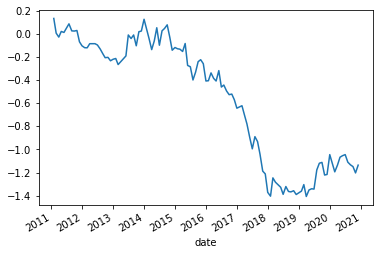

In [86]:
# IC 值累积曲线——随时间变化效果是否稳定
ic_series_cum.plot()

In [87]:
df_backtest = df_backtest.drop(columns = ['PE_TTM_resid'])

## Hiearachical Backtesting
分层回测

In [189]:
NUM_GROUPS = 5
GROUP_NAMES = [f"group{i}_weight" for i in range(1, NUM_GROUPS + 1)]

In [190]:
from functools import partial
assigned_group = df_backtest.groupby('pri_indus_code')['PE_TTM'].apply(partial(pd.qcut, q=5, labels=range(5)))

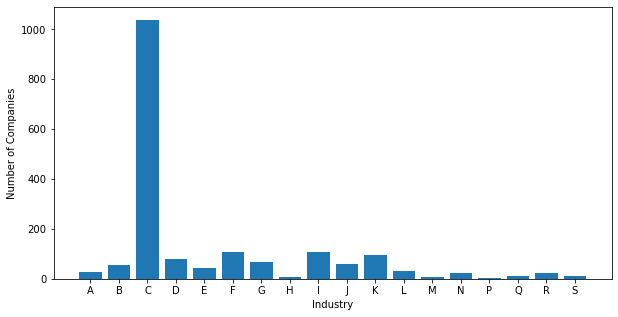

In [118]:
fig = plt.figure(figsize = (10, 5))
num_stocks_per_indus = df_backtest[df_backtest.index.get_level_values(0) == '2011-01-31'].groupby('pri_indus_code')['PE_TTM'].count()

plt.bar(*zip(*num_stocks_per_indus.items()))
 
plt.xlabel("Industry")
plt.ylabel("Number of Companies")
plt.show()

In [193]:
#Here for simplicity we assume that index weight is a uniform portfolio over all stocks, to be modified later
df_backtest['index_weight'] = df_backtest.groupby(level=0).apply(lambda df: pd.Series([1/df.shape[0]] * df.shape[0])).values

In [194]:
#merge the industry weights of the index onto the backtesting dataframe
def set_index_indus_weight(df):
    index_indus_weight = df.groupby('pri_indus_code')['index_weight'].sum().rename('index_indus_weight')
    df = df.merge(index_indus_weight, how='left', left_on='pri_indus_code', right_index=True)
    return df
#'index_indus_weight' = this stock's industry weight in the benchmark index
if 'index_indus_weight' not in df_backtest.columns:
    df_backtest = applyParallel(df_backtest.groupby(level=0), set_index_indus_weight)

In [195]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633   
           688369.XSHG   69.03   69.63             77.35            0.110872   
           688388.XSHG   62.18   60.00             86.90            0.448333   
           688389.XSHG   19.33   19.53             21.20            0.085509   
           688399.XSHG  185.00  184.79            190.40            0.030359   

                       secon_indus_code pri_indus_code  index_weight  \
date       stock                                                       
2011-01-31 000001.XSHE              J66              J      0.000557   
           000002.XSHE              K70              K      0.000557   
           000005.XSHE              N77              N      0.000557   
           000006.XSHE              K70              K      0.000557   
           000009.XSHE              S90              S      0.000557   
...                                 ...            ...           ...   
2020-11-30 688368.XSHG              I65              I      0.000285   
           688369.XSHG              I65              I      0.000285   
           688388.XSHG              C39              C      0.000285   
           688389.XSHG              C35              C      0.000285   
           688399.XSHG              C27              C      0.000285   

                        index_indus_weight  
date       stock                            
2011-01-31 000001.XSHE            0.033426  
           000002.XSHE            0.052368  
           000005.XSHE            0.013928  
           000006.XSHE            0.052368  
           000009.XSHE            0.006685  
...                                    ...  
2020-11-30 688368.XSHG            0.080820  
           688369.XSHG            0.080820  
           688388.XSHG            0.627775  
           688389.XSHG            0.627775  
           688399.XSHG            0.627775  

[297489 rows x 13 columns]

In [196]:
import numpy as np
# hiearchical backtesting is pretty hard to implement using purely vectorization/parrallelization, and I have to use for loop at least once.
def get_group_weight_by_industry(num_stocks, num_groups) -> np.array:
    """
    precondition: the stocks need to be sorted by factor exposure
    @num_stocks: the number of stocks in this industry
    @num_groups: the number of portfolio groups to be constructed
    
    returns: an intermediary (num_stocks x num_groups) weight matrix specifying the weight of 
             each stock in each group. Here weights within each group(column sum) adds up to 1.
             This is not the final weight matrix because there are many industries(so that weights within 
             each group should actually be smaller than one) but the returned
             weight matrix represents only one industry. 
    
    if you want to understand the algorithm deeper, print some intermediary outputs
    """
    num_rows = min(num_groups, num_stocks)
    num_cols = max(num_groups, num_stocks)
    weight_mat = np.zeros((num_rows, num_cols))
    remaining = 0
    j = 0
    row_budget = num_cols
    col_budget = num_rows
    for i in range(num_rows):
        # print(f"i = {i}")
        start = col_budget - remaining
        # print(f"start = {start}")
        weight_mat[i, j] = start
        offset = (row_budget - start) // col_budget
        # print(f"offset = {offset}")
        weight_mat[i, j + 1: j + 1 + offset] = col_budget
        remaining = row_budget - offset * col_budget - start
        j = j + 1 + offset
        if j < num_cols:
            weight_mat[i, j] = remaining
        
    weight_mat = weight_mat if num_groups > num_stocks else weight_mat.transpose()
    weight_mat_normalized = weight_mat / weight_mat.sum(axis=0)
    return weight_mat_normalized

def get_weight_df_by_industry(df: pd.DataFrame) -> pd.DataFrame:
    """get the weight dataframe for each industry"""
    #sort by the factor exposure
    df = df.sort_values(by='PE_TTM') 
    stock_names = df.index.get_level_values(1)
    #get weight matrix first
    weight_mat = get_group_weight_by_industry(stock_names.shape[0], NUM_GROUPS)
    df[GROUP_NAMES] = weight_mat
    return df

In [197]:
def get_group_weight_by_date(df_backtest_sub):
    #get the intermediary weights in each group on each rebalancing date
    df_backtest_sub = df_backtest_sub.groupby('pri_indus_code').apply(get_weight_df_by_industry).droplevel(0).sort_index(level=1)
    """
    we need to make the group portfolio industry-neutral with the index. That is, industry weights should be the same in both
    the group portfolio and the index. 
    """
    #multiply each stock's intermediary weight by its industry weight. since the intermediary weight within each group within each industry adds up to 1(as explained in the previous function),
    #after this operation the final stock weight within each group should add up to 1.
    df_backtest_sub[GROUP_NAMES] = np.multiply(df_backtest_sub[GROUP_NAMES].values, df_backtest_sub['index_indus_weight'].values[:, np.newaxis])
    return df_backtest_sub

In [198]:
df_backtest = df_backtest.groupby(level=0).apply(get_group_weight_by_date)

In [199]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633   
           688369.XSHG   69.03   69.63             77.35            0.110872   
           688388.XSHG   62.18   60.00             86.90            0.448333   
           688389.XSHG   19.33   19.53             21.20            0.085509   
           688399.XSHG  185.00  184.79            190.40            0.030359   

                       secon_indus_code pri_indus_code  index_weight  \
date       stock                                                       
2011-01-31 000001.XSHE              J66              J      0.000557   
           000002.XSHE              K70              K      0.000557   
           000005.XSHE              N77              N      0.000557   
           000006.XSHE              K70              K      0.000557   
           000009.XSHE              S90              S      0.000557   
...                                 ...            ...           ...   
2020-11-30 688368.XSHG              I65              I      0.000285   
           688369.XSHG              I65              I      0.000285   
           688388.XSHG              C39              C      0.000285   
           688389.XSHG              C35              C      0.000285   
           688399.XSHG              C27              C      0.000285   

                        index_indus_weight  group1_weight  group2_weight  \
date       stock                                                           
2011-01-31 000001.XSHE            0.033426       0.002786       0.000000   
           000002.XSHE            0.052368       0.000000       0.002786   
           000005.XSHE            0.013928       0.002786       0.000000   
           000006.XSHE            0.052368       0.000000       0.002786   
           000009.XSHE            0.006685       0.000000       0.000000   
...                                    ...            ...            ...   
2020-11-30 688368.XSHG            0.080820       0.000000       0.000000   
           688369.XSHG            0.080820       0.000000       0.000000   
           688388.XSHG            0.627775       0.000000       0.000000   
           688389.XSHG            0.627775       0.000000       0.000000   
           688399.XSHG            0.627775       0.000000       0.000000   

                  

In [200]:
df_backtest.groupby(level=0)[GROUP_NAMES].sum() #looks good

,group1_weight,group2_weight,group3_weight,group4_weight,group5_weight
date,,,,,
2011-01-31,1.0,1.0,1.0,1.0,1.0
2011-02-28,1.0,1.0,1.0,1.0,1.0
2011-03-31,1.0,1.0,1.0,1.0,1.0
2011-04-29,1.0,1.0,1.0,1.0,1.0
2011-05-31,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...
2020-07-31,1.0,1.0,1.0,1.0,1.0
2020-08-31,1.0,1.0,1.0,1.0,1.0
2020-09-30,1.0,1.0,1.0,1.0,1.0


In [201]:
def get_group_returns_by_date(df_backtest_sub):
    group_returns = df_backtest_sub[GROUP_NAMES].values.transpose() @ df_backtest_sub['next_period_return'].values
    group_returns = pd.Series(group_returns, index=GROUP_NAMES)
    return group_returns

group_returns_by_date = df_backtest.groupby(level=0).apply(get_group_returns_by_date)
group_returns_by_date

,group1_weight,group2_weight,group3_weight,group4_weight,group5_weight
date,,,,,
2011-01-31,0.084681,0.063083,0.076096,0.085148,0.099410
2011-02-28,0.013013,-0.015796,-0.034104,-0.046081,-0.001723
2011-03-31,-0.053097,-0.085688,-0.097448,-0.097303,-0.080639
2011-04-29,-0.112998,-0.133315,-0.140052,-0.163163,-0.115941
2011-05-31,0.003155,-0.008389,-0.008815,-0.005432,0.003378
...,...,...,...,...,...
2020-07-31,0.048069,0.051097,0.029108,0.032702,0.017566
2020-08-31,-0.057181,-0.061419,-0.066216,-0.070661,-0.071883
2020-09-30,0.027821,0.038110,0.031089,0.022691,0.029387


In [202]:
group_cum_returns= (group_returns_by_date + 1).cumprod(axis=0)
group_cum_returns

,group1_weight,group2_weight,group3_weight,group4_weight,group5_weight
date,,,,,
2011-01-31,1.084681,1.063083,1.076096,1.085148,1.099410
2011-02-28,1.098796,1.046291,1.039397,1.035143,1.097516
2011-03-31,1.040454,0.956637,0.938110,0.934421,1.009013
2011-04-29,0.922884,0.829103,0.806726,0.781958,0.892027
2011-05-31,0.925796,0.822147,0.799615,0.777711,0.895040
...,...,...,...,...,...
2020-07-31,1.295193,0.842762,0.682843,0.753853,0.777325
2020-08-31,1.221133,0.791000,0.637628,0.700585,0.721448
2020-09-30,1.255106,0.821146,0.657451,0.716482,0.742650


<AxesSubplot:xlabel='date'>

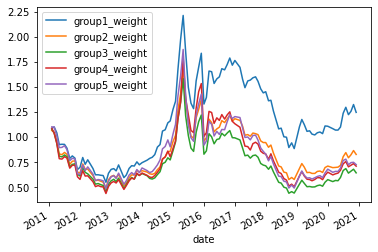

In [203]:
group_cum_returns.plot()

## Factor Combination

In [204]:
COMBINE_FACTORS = ['PE_TTM', 'PS_TTM']

In [205]:
def get_ic_series(factor, df_backtest=df_backtest):
    def wls_factor_resid(df):
        import statsmodels.formula.api as smf
        wls_result = smf.wls(formula = f"{factor} ~ 0 + market_value + C(pri_indus_code)", 
                        data=df, weights = df['market_value'] ** 0.5).fit()
        return wls_result.resid
    if f'{factor}_resid' not in df_backtest.columns:
        factor_resids = applyParallel(df_backtest.groupby(level=0), wls_factor_resid)
        factor_resids = factor_resids.rename(f'{factor}_resid')
        df_backtest = df_backtest.merge(factor_resids, how='left', left_index=True, right_index=True)
    def cross_sectional_ic(df):
        return df[['next_period_return', f'{factor}_resid']].corr(method='spearman').iloc[0, 1]
    ic_series = df_backtest.groupby(level=0).apply(cross_sectional_ic)
    return ic_series

In [206]:
df_backtest

PE_TTM    PS_TTM    PC_TTM        PB  market_value  \
date       stock                                                               
2011-01-31 000001.XSHE -0.014373 -0.180849 -0.034799 -0.624297  5.335556e+10   
           000002.XSHE -0.010409 -0.244898 -0.098121 -0.517621  7.937809e+10   
           000005.XSHE -0.045386  4.515417  0.296179 -0.057780  3.200168e+09   
           000006.XSHE -0.010921 -0.264959  0.532291 -0.454080  5.409109e+09   
           000009.XSHE  0.013805  0.019004 -0.094774  0.542904  1.937173e+10   
...                          ...       ...       ...       ...           ...   
2020-11-30 688368.XSHG  0.000000  0.000000  0.000000  0.000000  1.207400e+10   
           688369.XSHG  0.000000  0.000000  0.000000  0.000000  5.361000e+09   
           688388.XSHG  0.000000  0.000000  0.000000  0.000000  1.385300e+10   
           688389.XSHG  0.000000  0.000000  0.000000  0.000000  8.246000e+09   
           688399.XSHG  0.000000  0.000000  0.000000  0.000000  1.083200e+10   

                          open   close  next_period_open  next_period_return  \
date       stock                                                               
2011-01-31 000001.XSHE   15.20   15.31             15.81            0.032658   
           000002.XSHE    8.25    8.20              8.13           -0.008537   
           000005.XSHE    3.46    3.50              4.28            0.222857   
           000006.XSHE    7.15    7.11              7.22            0.015471   
           000009.XSHE   17.05   17.76             23.50            0.323198   
...                        ...     ...               ...                 ...   
2020-11-30 688368.XSHG  210.19  196.00            159.42           -0.186633   
           688369.XSHG   69.03   69.63             77.35            0.110872   
           688388.XSHG   62.18   60.00             86.90            0.448333   
           688389.XSHG   19.33   19.53             21.20            0.085509   
           688399.XSHG  185.00  184.79            190.40            0.030359   

                       secon_indus_code pri_indus_code  index_weight  \
date       stock                                                       
2011-01-31 000001.XSHE              J66              J      0.000557   
           000002.XSHE              K70              K      0.000557   
           000005.XSHE              N77              N      0.000557   
           000006.XSHE              K70              K      0.000557   
           000009.XSHE              S90              S      0.000557   
...                                 ...            ...           ...   
2020-11-30 688368.XSHG              I65              I      0.000285   
           688369.XSHG              I65              I      0.000285   
           688388.XSHG              C39              C      0.000285   
           688389.XSHG              C35              C      0.000285   
           688399.XSHG              C27              C      0.000285   

                        index_indus_weight  group1_weight  group2_weight  \
date       stock                                                           
2011-01-31 000001.XSHE            0.033426       0.002786       0.000000   
           000002.XSHE            0.052368       0.000000       0.002786   
           000005.XSHE            0.013928       0.002786       0.000000   
           000006.XSHE            0.052368       0.000000       0.002786   
           000009.XSHE            0.006685       0.000000       0.000000   
...                                    ...            ...            ...   
2020-11-30 688368.XSHG            0.080820       0.000000       0.000000   
           688369.XSHG            0.080820       0.000000       0.000000   
           688388.XSHG            0.627775       0.000000       0.000000   
           688389.XSHG            0.627775       0.000000       0.000000   
           688399.XSHG            0.627775       0.000000       0.000000   

                  

In [207]:
#The multiprocessing takes forever, not sure why
#had to use for loop for now. Look into this later

# with pathos.multiprocessing.ProcessPool(pathos.helpers.cpu_count()) as pool: 
#     ic_series_results = pool.map( get_ic_series, COMBINE_FACTORS)
ic_series_results = [get_ic_series(factor).rename(factor) for factor in COMBINE_FACTORS] #around 8 seconds
df_ic_series = pd.concat(ic_series_results, axis=1)

In [208]:
df_ic_series

,PE_TTM,PS_TTM
date,,
2011-01-31,0.122038,-0.023049
2011-02-28,-0.108788,-0.226326
2011-03-31,-0.039691,-0.158952
2011-04-29,0.044145,-0.055560
2011-05-31,-0.005144,0.005217
...,...,...
2020-07-31,-0.070473,-0.053090
2020-08-31,-0.013264,-0.020628
2020-09-30,-0.039684,0.003087


In [209]:
hist_periods = 12
df_ic_series.rolling(hist_periods, min_periods=hist_periods).mean()

,PE_TTM,PS_TTM
date,,
2011-01-31,NaN,NaN
2011-02-28,NaN,NaN
2011-03-31,NaN,NaN
2011-04-29,NaN,NaN
2011-05-31,NaN,NaN
...,...,...
2020-07-31,0.017158,0.014609
2020-08-31,0.002643,0.004395
2020-09-30,-0.005247,-0.005529


In [210]:
#leave the computation for later
# A = np.arange(6).reshape(2,3) # 2 x 3, N = 2, T = 3
# S = pd.DataFrame(A).T.cov() #2 x 2
# np.expand_dims(A, 0)

In [211]:
df_ic_cov_mat_series = df_ic_series.rolling(hist_periods, min_periods=hist_periods).cov()
df_ic_cov_mat_series

PE_TTM    PS_TTM
date                                 
2011-01-31 PE_TTM       NaN       NaN
           PS_TTM       NaN       NaN
2011-02-28 PE_TTM       NaN       NaN
           PS_TTM       NaN       NaN
2011-03-31 PE_TTM       NaN       NaN
...                     ...       ...
2020-09-30 PS_TTM  0.003591  0.003734
2020-10-30 PE_TTM  0.007071  0.003916
           PS_TTM  0.003916  0.004975
2020-11-30 PE_TTM  0.006446  0.002633
           PS_TTM  0.002633  0.004430

[224 rows x 2 columns]

#### maximize the ICIR values on a single rebalancing date

In [212]:
w = np.array([0.5, 0.5])

In [213]:
pd.date_range(START_DATE, END_DATE)

DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=3653, freq='D')

In [214]:
df_ic_hist_mean = df_ic_series.rolling(hist_periods, min_periods=hist_periods).mean()

In [215]:
df_ic_cov_mat_series = df_ic_series.rolling(hist_periods, min_periods=hist_periods).cov()

In [216]:
df_ic = df_ic_series[df_ic_series.index == '2020-09-30']
df_ic

,PE_TTM,PS_TTM
date,,
2020-09-30,-0.039684,0.003087


In [217]:
df_ic_cov_mat = df_ic_cov_mat_series[df_ic_cov_mat_series.index.get_level_values(0) == '2020-09-30']
df_ic_cov_mat

PE_TTM    PS_TTM
date                                 
2020-09-30 PE_TTM  0.007028  0.003591
           PS_TTM  0.003591  0.003734

In [218]:
w @ df_ic_cov_mat.values @ w.transpose()

0.004485995403002523

In [219]:
w.transpose() @ df_ic.values.flatten()

-0.018298650295172234

In [220]:
def get_ic_ir(factor_weights):
    ic_mean = factor_weights.transpose() @ df_ic.values.flatten()
    ic_var = factor_weights @ df_ic_cov_mat.values @ factor_weights.transpose()
    return ic_mean / (ic_var ** 0.5)

In [221]:
df_ic_cov_mat.shape

(2, 2)

In [222]:
num_factors = len(COMBINE_FACTORS)
opt_result = scipy.optimize.minimize(
                lambda w: -get_ic_ir(w),
                np.array([1 / num_factors] * num_factors),
                bounds=[(0, 1) for i in range(num_factors)],
                constraints=({"type": "eq", "fun": lambda weight: np.sum(weight) - 1})
            )
opt_factor_weight = opt_result.x

In [223]:
opt_factor_weight

array([0., 1.])

#### optimal factor weight on all rebalancing dates

In [224]:
df_ic_series.rolling(12).apply(lambda df: df.mean() )

,PE_TTM,PS_TTM
date,,
2011-01-31,NaN,NaN
2011-02-28,NaN,NaN
2011-03-31,NaN,NaN
2011-04-29,NaN,NaN
2011-05-31,NaN,NaN
...,...,...
2020-07-31,0.017158,0.014609
2020-08-31,0.002643,0.004395
2020-09-30,-0.005247,-0.005529


In [225]:
df_ic_series.index[hist_periods:]

DatetimeIndex(['2012-01-31', '2012-02-29', '2012-03-30', '2012-05-31',
               '2012-06-29', '2012-07-31', '2012-08-31', '2012-09-28',
               '2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31',
               '2013-02-28', '2013-03-29', '2013-05-31', '2013-06-28',
               '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31',
               '2013-11-29', '2013-12-31', '2014-02-28', '2014-03-31',
               '2014-04-30', '2014-05-30', '2014-06-30', '2014-07-31',
               '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28',
               '2014-12-31', '2015-01-30', '2015-02-27', '2015-03-31',
               '2015-04-30', '2015-05-29', '2015-06-30', '2015-07-31',
               '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30',
               '2015-12-31', '2016-01-29', '2016-02-29', '2016-03-31',
               '2016-04-29', '2016-05-31', '2016-06-30', '2016-07-29',
               '2016-08-31', '2016-09-30', '2016-10-31', '2016-11-30',
      

In [226]:
def get_opt_factor_weight_by_date(date): 
    df_ic = df_ic_series[df_ic_series.index == date]
    df_pred_ic = df_ic.rolling(hist_periods).mean()
    print('11111')
    print(df_pred_ic)
    df_pred_ic_cov_mat = df_ic.rolling(hist_periods).cov()
    print('a')
    def get_ic_ir(factor_weights):
        combined_ic_mean = factor_weights.transpose() @ df_pred_ic.values.flatten()
        combined_ic_var = factor_weights @ df_pred_ic_cov_mat.values @ factor_weights.transpose()
        combined_ir = combined_ic_mean / (combined_ic_var ** 0.5)
        return combined_ir
    print('b')
    opt_result = scipy.optimize.minimize(
                lambda w: -get_ic_ir(w),
                np.array([1 / num_factors] * num_factors),
                bounds=[(0, 1) for i in range(num_factors)],
                constraints=({"type": "eq", "fun": lambda weight: np.sum(weight) - 1})
            )
    print('c')
    opt_factor_weight = pd.Series(opt_result.x, index=COMBINE_FACTORS, name=date)
    print('d')
    return opt_result.x

In [227]:
valid_dates = df_ic_series.index[hist_periods:]
results = [get_opt_factor_weight_by_date(date) for date in valid_dates]

11111
            PE_TTM  PS_TTM
date                      
2012-01-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-02-29     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-03-30     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-05-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-06-29     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-07-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-08-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-09-28     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-10-31     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date                      
2012-11-30     NaN     NaN
a
b
c
d
11111
            PE_TTM  PS_TTM
date             

In [228]:
results #TBD: not sure why the optimization is not working, debug

[array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),
 array([0.5, 0.5]),


In [ ]:
#we cannot use pandas.rolling.apply(func) because rolling.apply is different from groupby.apply -- it cannot take a dataframe as the parameter


# num_factors = len(COMBINE_FACTORS)
# def get_opt_factor_weight_by_date(ic_series: pd.Series): 
#     df = df_ic_series.loc[ic_series.index, :]
#     df_pred_ic = df.mean()
#     print('11111')
#     print(df_pred_ic)
#     df_pred_ic_cov_mat = df.cov()
#     print('a')
#     def get_ic_ir(factor_weights):
#         combined_ic_mean = factor_weights.transpose() @ df_pred_ic.values.flatten()
#         combined_ic_var = factor_weights @ df_pred_ic_cov_mat.values @ factor_weights.transpose()
#         combined_ir = combined_ic_mean / (combined_ic_var ** 0.5)
#         return combined_ir
#     print('b')
#     opt_result = scipy.optimize.minimize(
#                 lambda w: -get_ic_ir(w),
#                 np.array([1 / num_factors] * num_factors),
#                 bounds=[(0, 1) for i in range(num_factors)],
#                 constraints=({"type": "eq", "fun": lambda weight: np.sum(weight) - 1})
#             )
#     print('c')
#     date = df.index[0]
#     opt_factor_weight = pd.Series(opt_result.x, index=COMBINE_FACTORS, name=date)
#     print('d')
#     return opt_result.x

# df_ic_series.rolling(12).apply(get_opt_factor_weight_by_date)